In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro, bartlett
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import qsturng


C:\Users\User\AppData\Local\Temp\ipykernel_186588\2963415979.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['budget_level'] = filtered_df['production_budget'].apply(budget_category)


5760
7896
5520


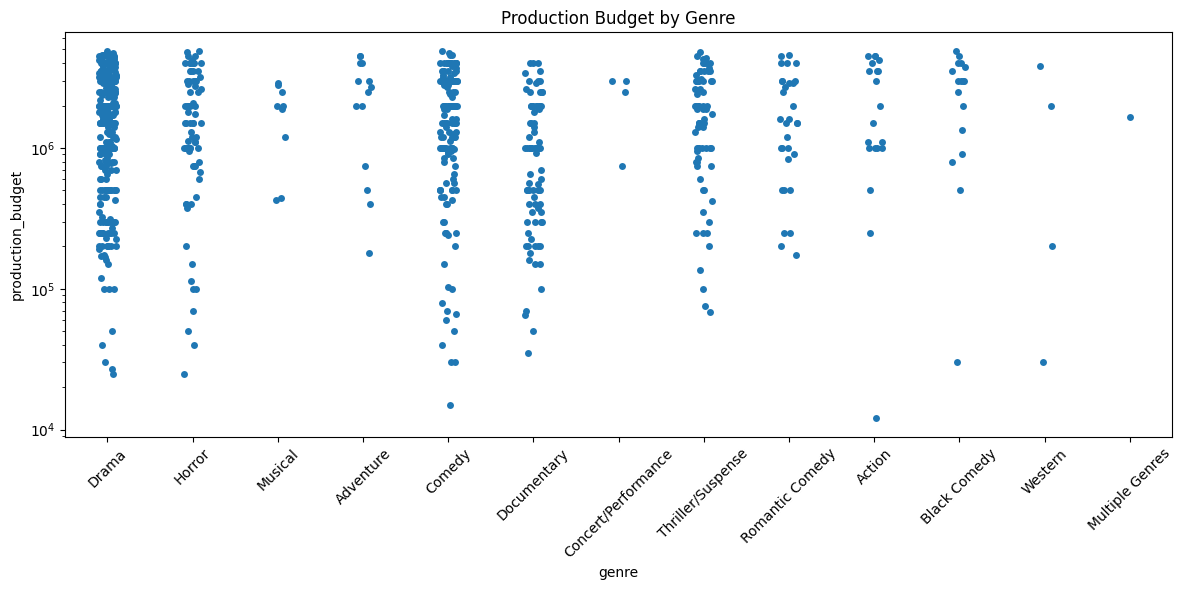

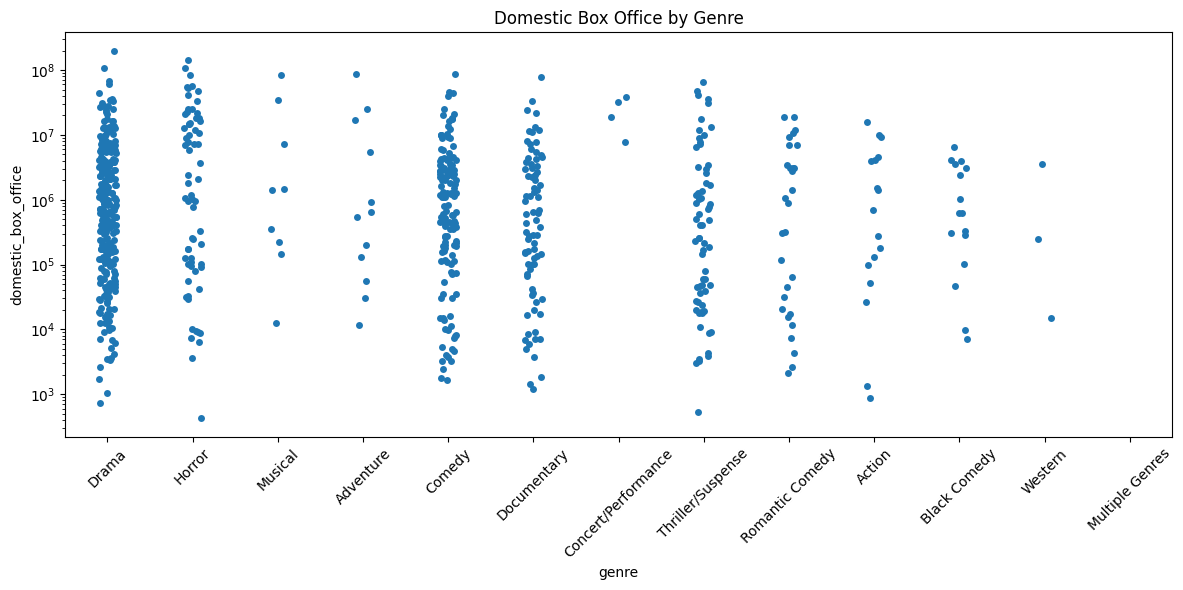

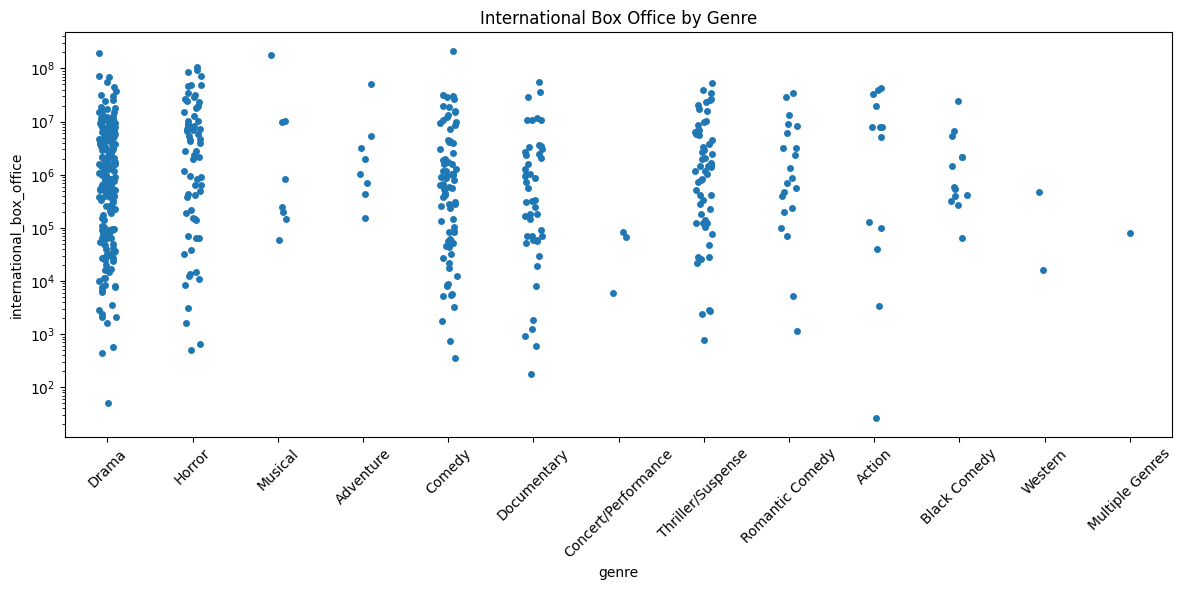

In [8]:
# Load data
df = pd.read_csv('movie_summary.csv')

# Filter by production year and budget
filtered_df = df[
    (df['genre'] != "Reality") &
    (df['production_budget'] < 5000000) &
    (df['production_budget'] > 10000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
]

def budget_category(budget):
    if budget < 1_000_000:
        return 'Low'
    elif budget < 3_000_000:
        return 'Mid'
    else:
        return 'High'

filtered_df['budget_level'] = filtered_df['production_budget'].apply(budget_category)

print(filtered_df[filtered_df['budget_level'] == 'Low'].size)
print(filtered_df[filtered_df['budget_level'] == 'Mid'].size)
print(filtered_df[filtered_df['budget_level'] == 'High'].size)

# Strip plot (with jitter to separate overlapping points)
plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='production_budget', jitter=True)
plt.yscale('log')
plt.title("Production Budget by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("budget_strip_plot")
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='domestic_box_office', jitter=True)
plt.yscale('log')
plt.title("Domestic Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='international_box_office', jitter=True)
plt.yscale('log')
plt.title("International Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

$$
\begin{aligned}
H_0: &\text{The box office of the movies of different genres are eqivalent.} \\
H_1: &\text{The box office of the movies of at least one genre is different from others.}
\end{aligned}
$$

In [3]:
# ---------------------------
# Shapiro-Wilk Normality Test (per genre group)
# ---------------------------
print("=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===")
genre_groups = filtered_df.groupby('genre')['domestic_box_office']

for genre, values in genre_groups:
    if len(values) >= 3:  # Shapiro-Wilk requires at least 3 values
        stat, p = shapiro(values)
        print(f"Genre: {genre:<20} | W = {stat:.4f} | p = {p:.4f}")

# ---------------------------
# Bartlett's Test (Equal variances across genres)
# ---------------------------
# Collect lists of values per genre
grouped_values = [  group['domestic_box_office'].values 
                    for name, group in filtered_df.groupby('genre') 
                    if len(group) >= 3  ]

print("\n=== Bartlett's Test (Domestic Box Office across Genres) ===")
bartlett_stat, bartlett_p = bartlett(*grouped_values)
print(f"Bartlett's Test: stat = {bartlett_stat:.4f} | p = {bartlett_p:.4f}\n")

=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===
Genre: Action               | W = 0.6682 | p = 0.0000
Genre: Adventure            | W = 0.4884 | p = 0.0000
Genre: Black Comedy         | W = 0.7926 | p = 0.0016
Genre: Comedy               | W = 0.4217 | p = 0.0000
Genre: Concert/Performance  | W = 0.9587 | p = 0.7709
Genre: Documentary          | W = 0.3775 | p = 0.0000
Genre: Drama                | W = 0.3005 | p = 0.0000
Genre: Horror               | W = 0.5514 | p = 0.0000
Genre: Musical              | W = 0.5955 | p = 0.0001
Genre: Romantic Comedy      | W = 0.6804 | p = 0.0000
Genre: Thriller/Suspense    | W = 0.4408 | p = 0.0000
Genre: Western              | W = 0.6802 | p = 0.0067

=== Bartlett's Test (Domestic Box Office across Genres) ===
Bartlett's Test: stat = 267.7584 | p = 0.0000



In [4]:
from scipy.stats import kruskal

# Ensure filtered_df['genre'] is clean and non-null
groups = [group['domestic_box_office'].values for name, group in filtered_df.groupby('genre') if len(group) >= 5]

# Run test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")

Kruskal-Wallis H = 13.292, p = 0.1498


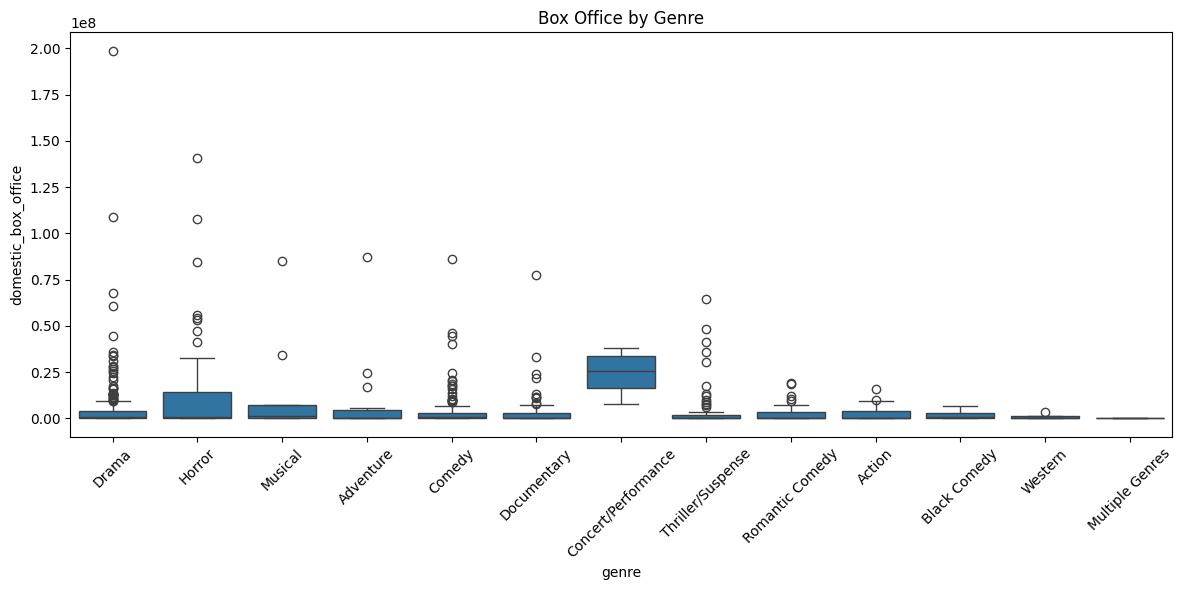

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='genre', y='domestic_box_office')
plt.xticks(rotation=45)
plt.title("Box Office by Genre")
plt.tight_layout()
plt.show()

In [6]:
# Ensure filtered_df['genre'] is clean and non-null
groups = [group['international_box_office'].values for name, group in filtered_df.groupby('genre') if len(group) >= 5]

# Run test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")

Kruskal-Wallis H = 48.780, p = 0.0000


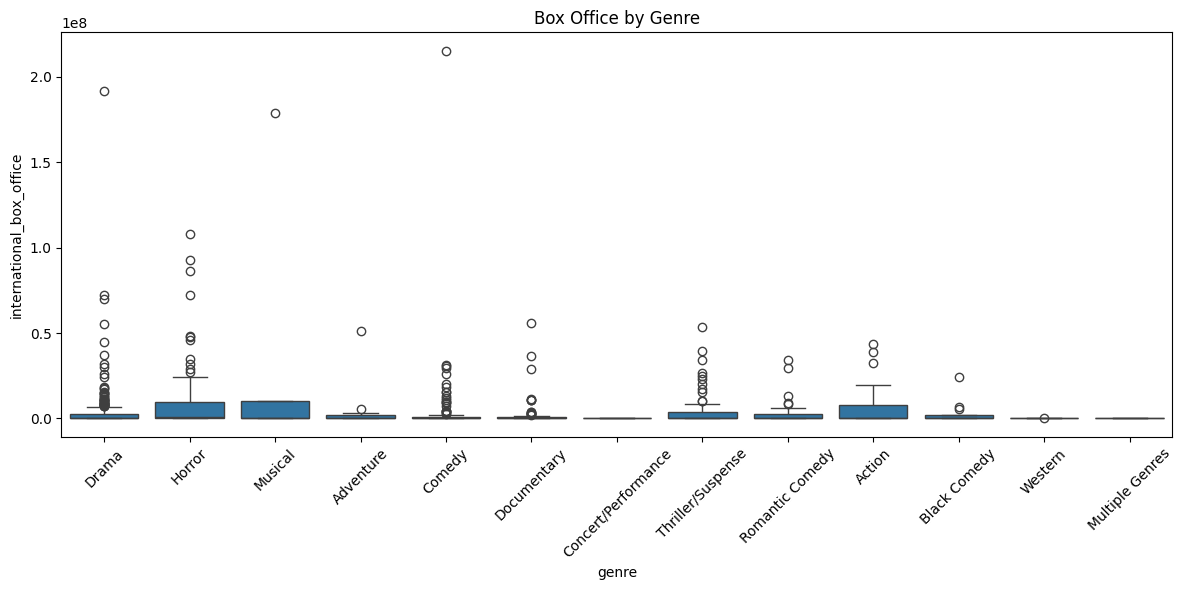

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='genre', y='international_box_office')
plt.xticks(rotation=45)
plt.title("Box Office by Genre")
plt.tight_layout()
plt.show()